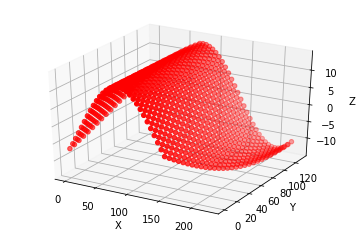

In [323]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from math import *
from mpl_toolkits.mplot3d import Axes3D

num = 30
end = 150.0
u = np.linspace(0, end, endpoint=True, num=num)
v = np.linspace(0, end, endpoint=True, num=num)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()
x0 = u + cos(pi/3)*v
y0 = sin(pi/3)*v
tri = mtri.Triangulation(x0, y0)

z0 = 13.5*np.sin(2 * pi * (u + cos(pi/3) * v - 20) / 240)

def find_normal(triangles, x=x0, y=y0, z=z0):
    normals, centers = [], []
    for triangle in triangles:
        coords = np.array([x[triangle], y[triangle], z[triangle]]).T
        norm = np.cross(coords[1] - coords[0], coords[2] - coords[0])
        normals.append((norm if norm[-1] >= 0 else norm * -1) / np.linalg.norm(norm))
        centers.append(np.mean(coords, axis=0))
    sorted_norms = np.array(sorted(np.hstack([centers, normals, triangles]), key=lambda x: (x[1], x[0], x[2])))
    return sorted_norms[:, 3:6], sorted_norms[:, :3], sorted_norms[:, 6:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x0, y0, z0, c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

norms, cents, new_tri = find_normal(tri.triangles)
ax.quiver(cents[:, 0], cents[:, 1], cents[:, 2], norms[:, 0], norms[:, 1], norms[:, 2], length=0.01)
plt.show()

def energy(triangles, x=x0, y=y0, z=z0, S=1, B=1e-3, a0=lambda x: end/(num - 1), verbose=True):
    norms, cents, new_tri = find_normal(triangles, x, y, z)
    s_energy, b_energy = 0, 0
    already_added = dict()
    for triangle in new_tri:
        coords = np.array([x[triangle.astype(int)], y[triangle.astype(int)], z[triangle.astype(int)]]).T
        for pair in [[0, 1], [0, 2], [1, 2]]:
            key = tuple(sorted(triangle[pair]))
            if key not in already_added:
                s_energy += (np.linalg.norm(coords[pair[0]] - coords[pair[1]]) - \
                             a0((coords[pair[0]][0] + coords[pair[1]][0])/2)) ** 2
                already_added[key] = 1
    s_energy *= sqrt(3)/4*S
    triangles = dict()
    for i, triangle in enumerate(new_tri.astype(int)):
        low, high = max(i - num * 2, 0), min(i + num * 2, len(new_tri))
        for j, tri in enumerate(new_tri[low:high].astype(int)):
            overlap = 0
            for vertex in tri:
                if vertex in triangle:
                    overlap += 1
            if overlap == 2 and j + low not in triangles:
                b_energy += np.linalg.norm(norms[i] - norms[j + low]) ** 2
        triangles[i] = 1
    b_energy *= B/sqrt(3)
    if verbose: print("Stretching:", s_energy, "Bending:", b_energy, "Total:", s_energy + b_energy)
    return s_energy + b_energy

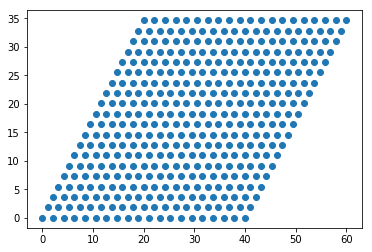

In [258]:
plt.scatter(x0, y0)
plt.show()

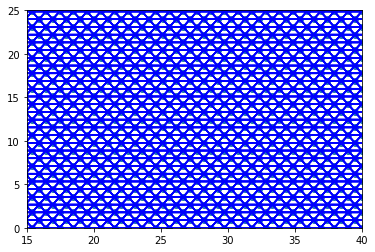

In [282]:
plt.scatter(x0, y0)
for t in tri.triangles:
    for pair in [[0, 1], [0, 2], [1, 2]]:
        plt.plot([x0[t[0]], x0[t[1]], x0[t[2]], x0[t[0]]],[y0[t[0]], y0[t[1]], y0[t[2]], y0[t[0]]], c='b')
plt.xlim(15, 40)
plt.ylim(0, 25)
plt.show()

0.03090307442850111
0.028312323991473466
0.09011851426228308
0.1992963910265462
0.14008097854320384
0.08086556644800937
0.08752776382525562
0.14674316224522982
0.3177272159932302
0.3769426280884246
0.2585118035098882
0.1992963914146935
0.021650153964667435
0.080865566059862
0.1493340369236809
0.09011863850370677
0.2085494767574632
0.09011859708989903
0.030903198669924463
0.030903157256116785
0.149333995509873
0.028312241163857846
0.32698023218360417
0.3861956720173866
0.44541107043736083
0.0875277224114475
0.14008097893135157
0.4454111118511687
0.32698027359741216
0.4953734538314038
0.20854943534365536
0.08752768099764013
0.26776479234982237
0.3861956306035789
0.32698019076979656
0.20854935251603973
0.14933391268225799
0.1493339540960655
0.2677647509360143
0.7414881453648485
0.6230573071110921
0.6822727469448742
0.19929639257913642
0.7414881867786565
0.02165015357651906
0.09678067100201597
0.037565258518674774
0.15599608309721136
0.08086556722430413
0.1400809793194992
0.021650154740962

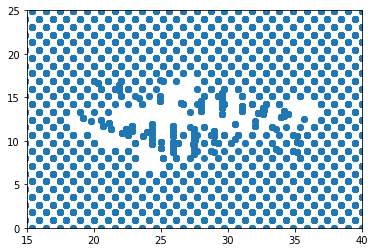

In [314]:
old_triangles, cuts, new_x, new_y, new_z, projs = z_plasty([27.5, 17.5], [27.5, 7.5], [18.83975, 12.5], [36.160254, 12.5], triangles=tri.triangles, x=x0, y=y0, z=z0)
plt.scatter(new_x[old_triangles.flatten()], new_y[old_triangles.flatten()])
# for t in new_triangles:
#     for pair in [[0, 1], [0, 2], [1, 2]]:
#         plt.plot([new_x[t[0]], new_x[t[1]], new_x[t[2]], new_x[t[0]]],[new_y[t[0]], new_y[t[1]], new_y[t[2]], new_y[t[0]]], c='b')
plt.xlim(15, 40)
plt.ylim(0, 25)
plt.show()

In [313]:
def z_plasty(a, b, c, d, triangles=tri.triangles, x=x0, y=y0, z=z0):
    new_tri, ab_cut = make_cut(a, b, triangles, x, y, z)
    new_tri, ac_cut = make_cut(a, c, new_tri, x, y, z)
    new_tri, bd_cut = make_cut(b, d, new_tri, x, y, z)
    x, y, z = x.copy(), y.copy(), z.copy()
    def inside(a, b, c, pt):  
        def area(a, b, c):
            return abs((a[0] * (b[1] - c[1]) + b[0] * (c[1] - a[1]) + c[0] * (a[1] - b[1])) / 2) 
        return area(a, b, c) == area([x[pt], y[pt]], b, c) + area(a, [x[pt], y[pt]], c) + area(a, b, [x[pt], y[pt]])
    def line(p1, p2):
        A = (p1[1] - p2[1])
        B = (p2[0] - p1[0])
        C = (p1[0]*p2[1] - p2[0]*p1[1])
        return A, B, -C
    def intersection(L1, L2):
        D  = L1[0] * L2[1] - L1[1] * L2[0]
        Dx = L1[2] * L2[1] - L1[1] * L2[2]
        Dy = L1[0] * L2[2] - L1[2] * L2[0]
        if D != 0:
            x = Dx / D
            y = Dy / D
            return np.array([x,y])
        else:
            print("Error")
            return False
    pts = dict()
    projs = []
    for tri in new_tri:
        if inside(a, b, c, tri[0]):
            for pt in tri:
                if pt not in pts:
                    projected = intersection(line([x[pt], y[pt]], a), line(b, c))
                    projs.append(projected)
                    factor = np.linalg.norm(projected - np.array([x[pt], y[pt]])) / np.linalg.norm(projected - a)
                    print(factor)
                    x[pt], y[pt] = (projected + factor * (d - projected))[0], (projected + factor * (d - projected))[1]
                    pts[pt] = 1
        elif inside(a, b, d, tri[0]):
            for pt in tri:
                if pt not in pts:
                    projected = intersection(line([x[pt], y[pt]], b), line(a, d))
                    projs.append(projected)
                    factor = np.linalg.norm(projected - np.array([x[pt], y[pt]])) / np.linalg.norm(projected - b)
                    print(factor)
                    x[pt], y[pt] = (projected + factor * (c - projected))[0], (projected + factor * (c - projected))[1]
                    pts[pt] = 1
    xs, ys = [], []
    pts = dict()
    for cut in [ab_cut, ac_cut, bd_cut]:
        for tri in cut:
            for pt in tri:
                if pt not in pts:
                    xs.append(x[pt])
                    ys.append(y[pt])
                    pts[pt] = 1
    new_triangles = mtri.Triangulation(xs, ys).triangles
    return new_tri, new_triangles, x, y, z + np.random.normal(0, 1e-3, z.shape[0]), projs

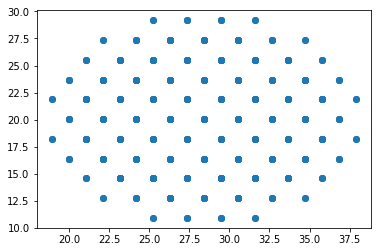

Stretching: 2.8127110419180674e-27 Bending: 0.0 Total: 2.8127110419180674e-27
2.8127110419180674e-27


In [246]:
def circle(r, x0, y0, triangles=tri.triangles, x=x0, y=y0, z=z0):
    def helper(pt):
        return sqrt((x[pt] - x0)**2 + (y[pt] - y0)**2) < r
    indices = []
    for i, triangle in enumerate(triangles):
        if helper(triangle[0]) and helper(triangle[1]) and helper(triangle[2]):
            indices.append(i)
    return triangles[indices]

triangles = circle(10, 28.33, 20)
plt.scatter(x0[triangles.flatten()], y0[triangles.flatten()])
plt.show()

print(energy(tri.triangles))

In [248]:
count = 0
lr = 0.001
x1, y1, z1 = x0.copy(), y0.copy(), z0.copy()
old_x, old_y, old_z = np.zeros(x0.shape), np.zeros(y0.shape), np.zeros(z0.shape)
dx, dy, dz = np.ones(x0.shape), np.ones(y0.shape), np.ones(z0.shape)
data2 = []
xs, ys = [], []
while np.linalg.norm(dx) > 1e-3 or np.linalg.norm(dy) > 1e-3 or np.linalg.norm(dz) > 1e-3:
    if count % 1000 == 0:
        print("Iteration:", count)
        data2.append(energy(triangles, x1, y1, z1, a0=lambda x: 2*end/(num - 1)))
        xs.append(x1.copy())
        ys.append(y1.copy())
        if data2[-1] < 1:
            break
    dx, dy, dz = denergy(x1, y1, z1, triangles, a0=lambda x: 2*end/(num - 1))
    old_x, old_y, old_z = x1.copy(), y1.copy(), z1.copy()
    x1 -= lr * dx
    y1 -= lr * dy
    z1 -= lr * dz
    count += 1
    if np.linalg.norm(dx) > 1e7 or np.linalg.norm(dy) > 1e7 or np.linalg.norm(dz) > 1e7:
        print("Overflow")
        break

Iteration: 0
Stretching: 426.05571111389554 Bending: 0.0 Total: 426.05571111389554
Iteration: 1000
Stretching: 232.3385607915299 Bending: 0.02422600555304015 Total: 232.36278679708292
Iteration: 2000
Stretching: 68.64350766072324 Bending: 0.11502614266322506 Total: 68.75853380338647
Iteration: 3000
Stretching: 36.058459999645535 Bending: 0.13484959021759121 Total: 36.19330958986313
Iteration: 4000
Stretching: 19.364698503795097 Bending: 0.13349875746852818 Total: 19.498197261263623
Iteration: 5000
Stretching: 12.885080319882189 Bending: 0.1315887778449462 Total: 13.016669097727135
Iteration: 6000
Stretching: 9.717128899731414 Bending: 0.13277649612217712 Total: 9.849905395853591
Iteration: 7000
Stretching: 7.820240303513477 Bending: 0.13242561595763688 Total: 7.952665919471113
Iteration: 8000
Stretching: 6.491340350402556 Bending: 0.13281036107768404 Total: 6.62415071148024
Iteration: 9000
Stretching: 5.465430435025301 Bending: 0.13465914214585126 Total: 5.600089577171152
Iteration: 10

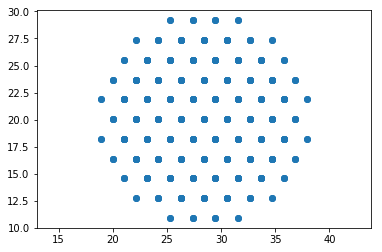

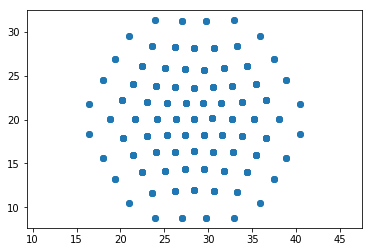

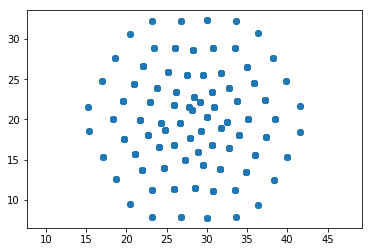

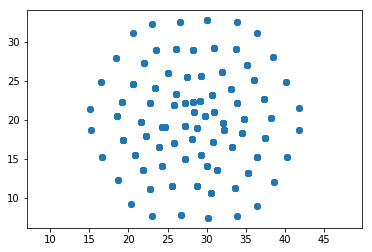

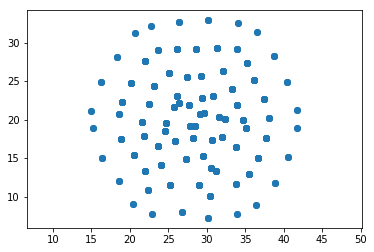

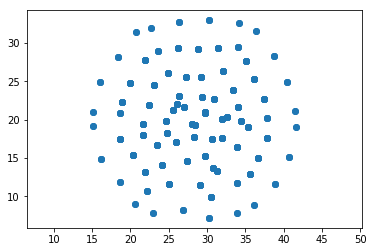

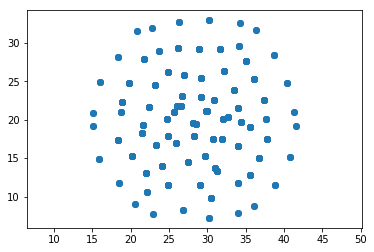

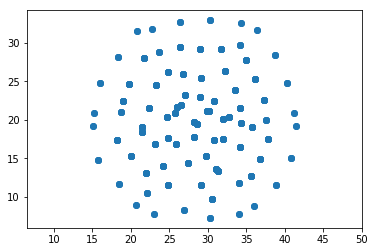

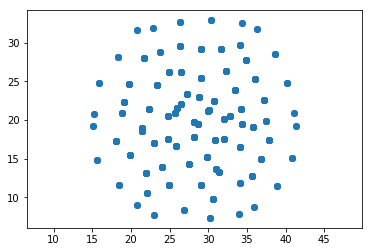

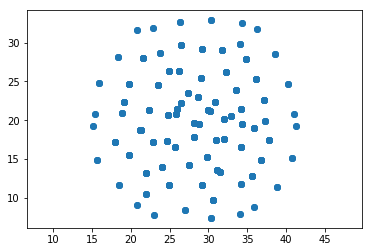

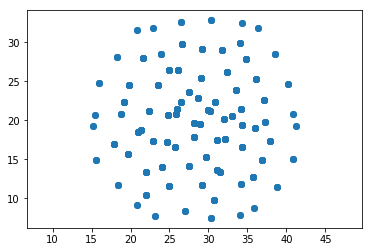

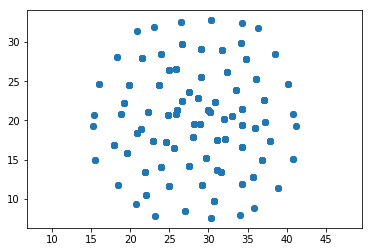

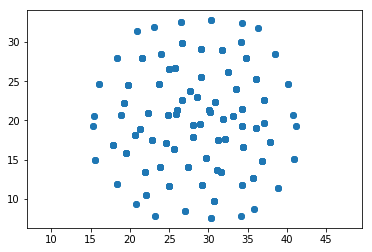

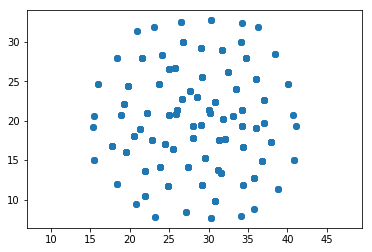

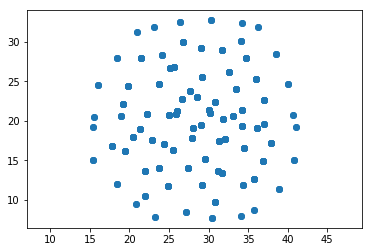

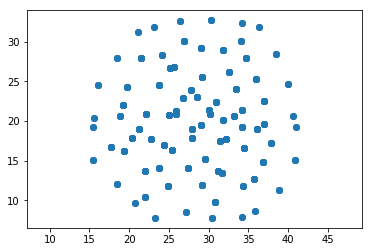

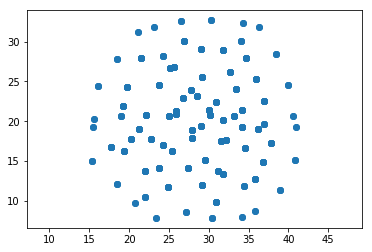

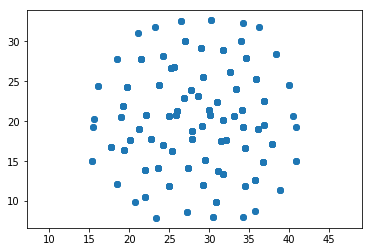

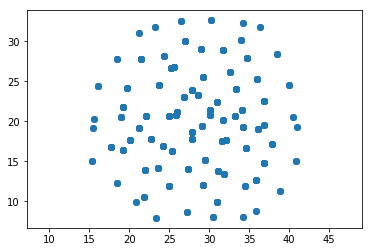

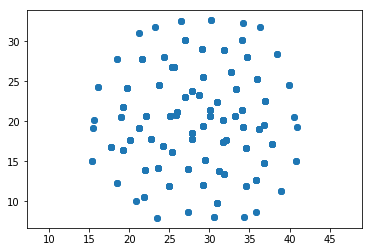

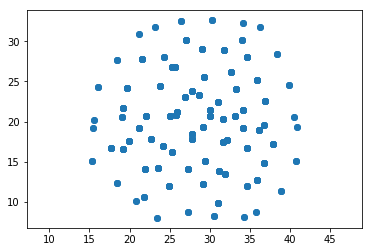

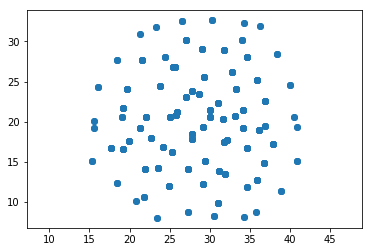

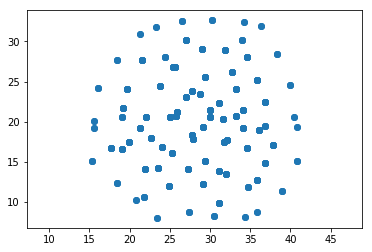

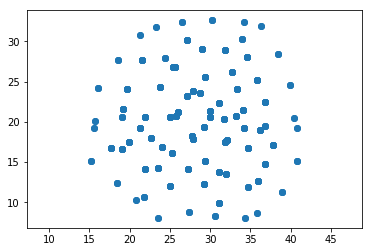

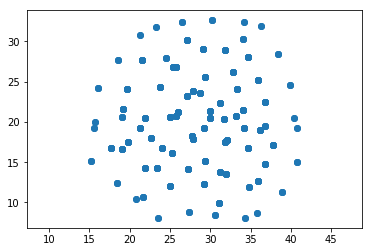

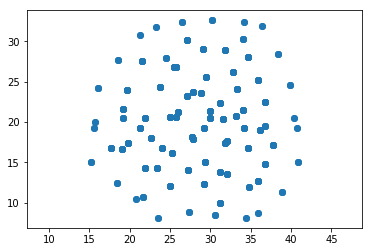

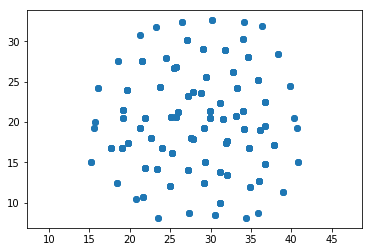

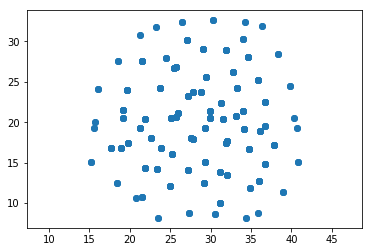

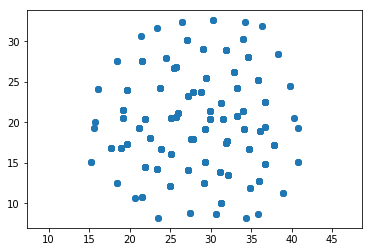

In [253]:
for i in range(len(xs)):
    plt.scatter(xs[i][triangles.flatten()], ys[i][triangles.flatten()])
    plt.xlim(10, 45)
    plt.ylim(0, 40)
    plt.axis('equal')
    plt.show()

In [319]:
count = 0
lr = 0.001
x1, y1, z1 = xs[-1].copy(), ys[-1].copy(), z0.copy()
old_x, old_y, old_z = np.zeros(x1.shape), np.zeros(y1.shape), np.zeros(z1.shape)
dx, dy, dz = np.ones(x1.shape), np.ones(y1.shape), np.ones(z1.shape)
while np.linalg.norm(dx) > 1e-3 or np.linalg.norm(dy) > 1e-3 or np.linalg.norm(dz) > 1e-3:
    if count % 1000 == 0:
        print("Iteration:", count)
        data2.append(energy(triangles, x1, y1, z1, a0=lambda x: 2*end/(num - 1)))
        xs.append(x1.copy())
        ys.append(y1.copy())
        if data2[-1] < 0.5:
            break
    dx, dy, dz = denergy(x1, y1, z1, triangles, a0=lambda x: 2*end/(num - 1))
    old_x, old_y, old_z = x1.copy(), y1.copy(), z1.copy()
    x1 -= lr * dx
    y1 -= lr * dy
    z1 -= lr * dz
    count += 1
    if np.linalg.norm(dx) > 1e7 or np.linalg.norm(dy) > 1e7 or np.linalg.norm(dz) > 1e7:
        print("Overflow")
        break

Iteration: 0
Stretching: 246.78117989943118 Bending: 0.0 Total: 246.78117989943118


ValueError: operands could not be broadcast together with shapes (1600,) (400,) 

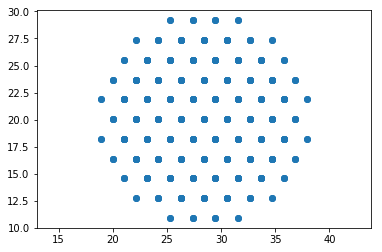

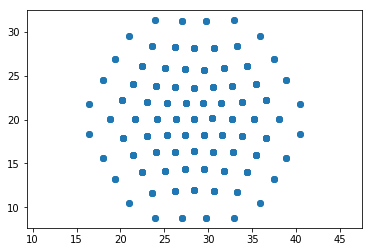

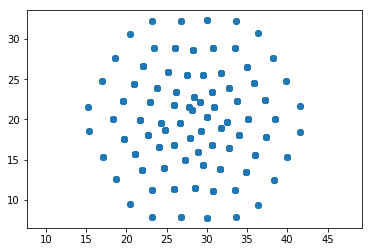

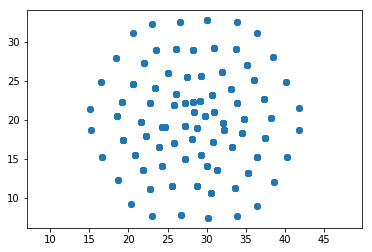

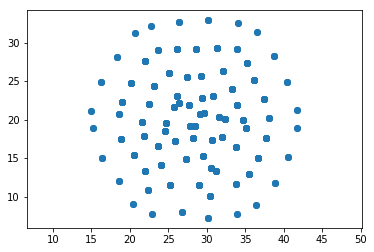

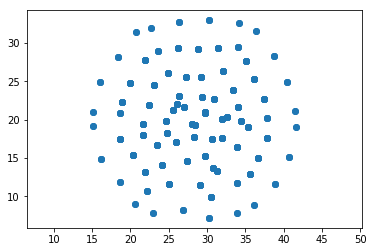

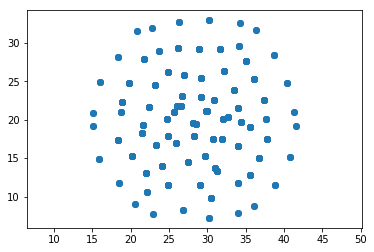

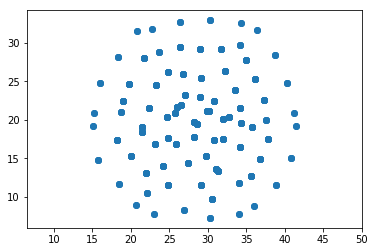

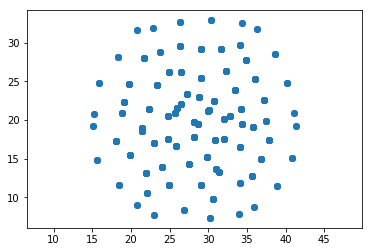

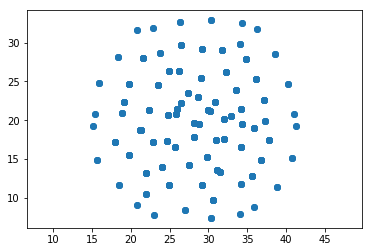

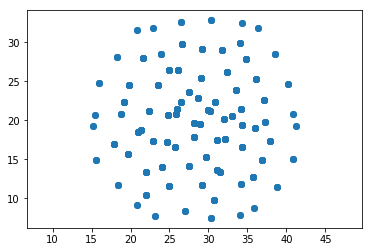

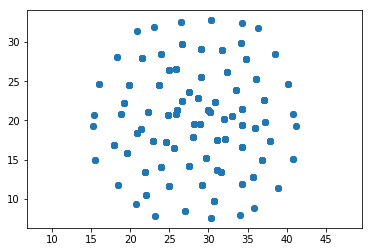

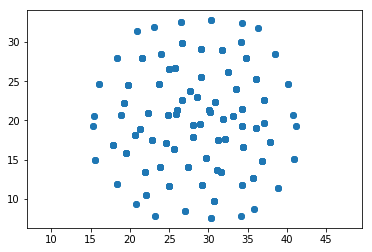

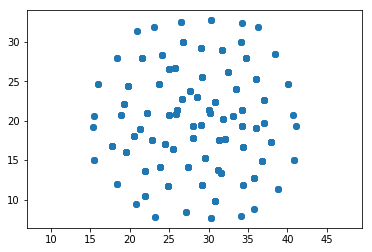

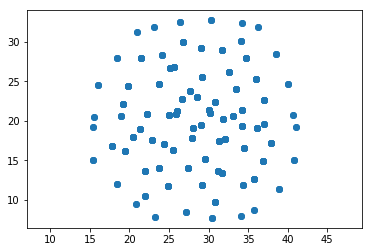

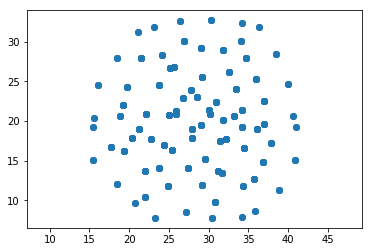

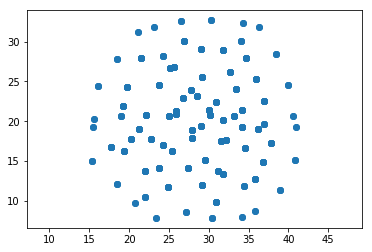

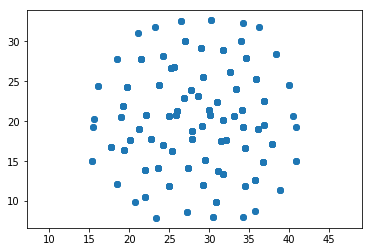

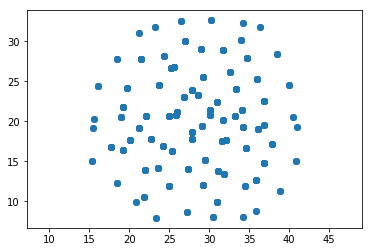

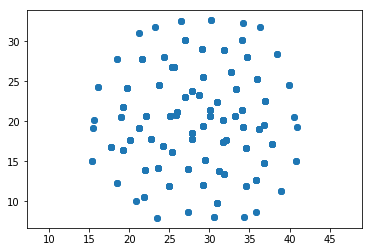

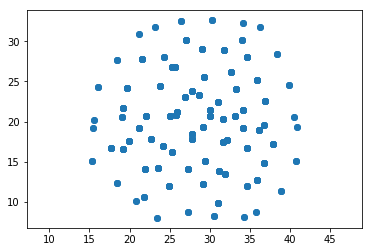

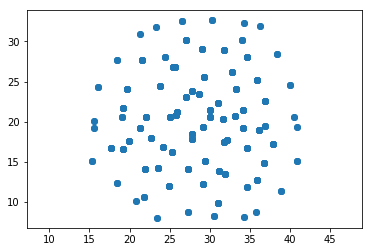

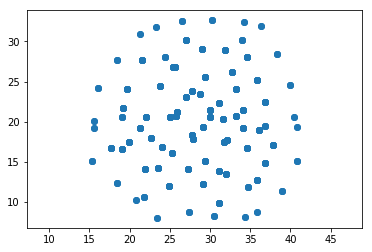

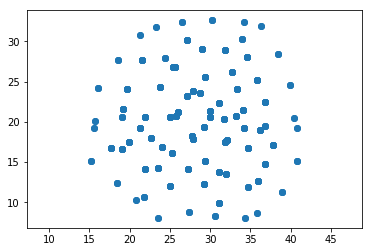

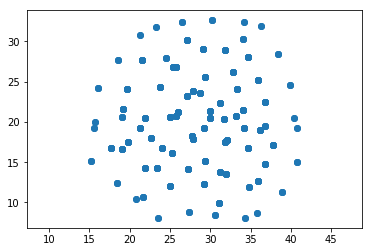

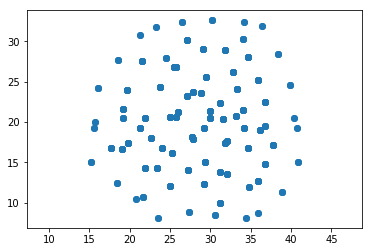

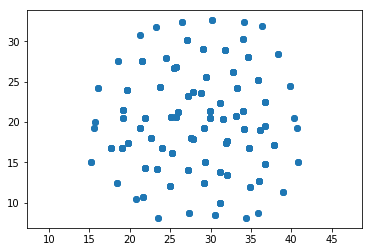

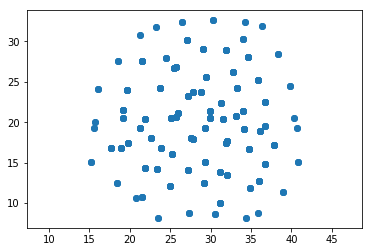

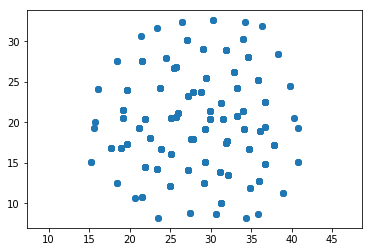

In [317]:
for i in range(len(xs)):
    plt.scatter(xs[i][triangles.flatten()], ys[i][triangles.flatten()])
    plt.xlim(10, 45)
    plt.ylim(0, 40)
    plt.axis('equal')
    plt.show()

In [40]:
def strip(W, x0, y0, triangles=tri.triangles, x=x0, y=y0, z=z0):
    def helper(pt):
        return x[pt] >= x0 and x[pt] <= x0 + 6*W and y[pt] >= y0 and y[pt] <= y0 + 2*W
    indices = []
    for i, triangle in enumerate(triangles):
        if helper(triangle[0]) and helper(triangle[1]) and helper(triangle[2]):
            indices.append(i)
    return triangles[indices]

In [190]:
triangles1 = strip(20, 20, 0)
energy(triangles1)

Stretching: 6.181354587794802e-27 Bending: 0.0 Total: 6.181354587794802e-27


6.181354587794802e-27

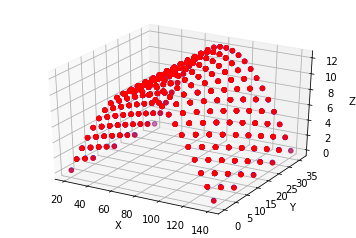

In [223]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x0[triangles1.flatten()], y0[triangles1.flatten()], z0[triangles1.flatten()], c='b', marker='o')
ax.scatter(xs[-1][triangles1.flatten()], ys[-1][triangles1.flatten()], zs[-1][triangles1.flatten()], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

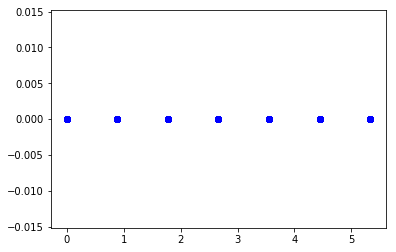

In [321]:
plt.scatter(y0[triangles1.flatten()], z0[triangles1.flatten()], c='b', marker='o')
plt.show()

In [5]:
np.dot(np.array([1, 1, 1]), np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]))

array([12, 15, 18])

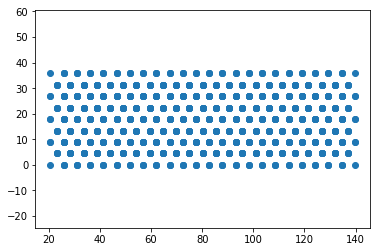

In [201]:
plt.scatter(x2[triangles1.flatten()], y2[triangles1.flatten()])
plt.axis('equal')
plt.show()

In [245]:
def denergy(x=x0, y=y0, z=z0, triangles=tri.triangles, S=1, B=1e-3, a0=lambda x: end/(num - 1), a0prime=lambda x: 0, noise=1e-1):
    dx, dy, dz = np.zeros(x.shape), np.zeros(y.shape), np.zeros(z.shape)
    already_added = dict()
    for triangle in triangles:
        coords = np.array([x[triangle.astype(int)], y[triangle.astype(int)], z[triangle.astype(int)]]).T
        for pair in [[0, 1], [0, 2], [1, 2]]:
            key = tuple(sorted(triangle[pair]))
            if key not in already_added:
                factor = (np.linalg.norm(coords[pair[0]] - coords[pair[1]]) - a0((coords[pair[0]][1] + coords[pair[1]][1]/2))) \
                        / np.linalg.norm(coords[pair[0]] - coords[pair[1]])
                dx[triangle[pair[0]]] += factor * (coords[pair[0]] - coords[pair[1]])[0]
                dy[triangle[pair[0]]] += factor * (coords[pair[0]] - coords[pair[1]])[1] - a0prime((coords[pair[0]][1] + coords[pair[1]][1]/2)) * (np.linalg.norm(coords[pair[0]] - coords[pair[1]]) - a0((coords[pair[0]][1] + coords[pair[1]][1]/2)))
                dz[triangle[pair[0]]] += factor * (coords[pair[0]] - coords[pair[1]])[2]
                dx[triangle[pair[1]]] += factor * (coords[pair[1]] - coords[pair[0]])[0]
                dy[triangle[pair[1]]] += factor * (coords[pair[1]] - coords[pair[0]])[1] - a0prime((coords[pair[0]][1] + coords[pair[1]][1]/2)) * (np.linalg.norm(coords[pair[0]] - coords[pair[1]]) - a0((coords[pair[0]][1] + coords[pair[1]][1]/2)))
                dz[triangle[pair[1]]] += factor * (coords[pair[1]] - coords[pair[0]])[2]
                already_added[key] = 1
    dx *= sqrt(3)/2*S
    dy *= sqrt(3)/2*S
    dz *= sqrt(3)/2*S
    centers = []
    for triangle in triangles:
        coords = np.array([x[triangle], y[triangle], z[triangle]]).T
        centers.append(np.mean(coords, axis=0))
    sorted_cents = np.array(sorted(np.hstack([centers, triangles]), key=lambda x: (x[1], x[0], x[2])))
    new_tri = sorted_cents[:, 3:]
    tris = dict()
    for i, triangle in enumerate(new_tri.astype(int)):
        low, high = max(i - num * 2, 0), min(i + num * 2, len(new_tri))
        for j, neighbor in enumerate(new_tri[low:high].astype(int)):
            overlap = 0
            for vertex in neighbor:
                if vertex in triangle:
                    overlap += 1
            if overlap == 2 and j + low not in tris:
                coords1, coords2 = np.array([x[triangle], y[triangle], z[triangle]]).T, np.array([x[neighbor], y[neighbor], z[neighbor]]).T
                for ind1 in range(3):
                    ind2 = np.nonzero(neighbor == triangle[ind1])[0][0] if triangle[ind1] in neighbor else 0
                    norm1 = np.cross(coords1[ind1] - coords1[(ind1+1)%3], coords1[(ind1+2)%3] - coords1[(ind1+1)%3])
                    negate1 = 1 if norm1[-1] >= 0 else -1
                    norm1 *= negate1 / np.linalg.norm(norm1)
                    norm2 = np.cross(coords2[ind2] - coords2[(ind2+1)%3], coords2[(ind2+2)%3] - coords2[(ind2+1)%3])
                    negate2 = 1 if norm2[-1] >= 0 else -1
                    norm2 *= negate2 / np.linalg.norm(norm2)
                    d1 = coords1[ind1] - coords1[(ind1+1)%3]
                    d2 = coords2[ind1] - coords2[(ind1+1)%3]
                    dxnorm1 = negate1 * np.cross([np.linalg.norm(d1[1:])**2, -d1[0]*d1[1], -d1[0]*d1[2]], coords1[(ind1+2)%3] - coords1[(ind1+1)%3]) / np.linalg.norm(coords1[ind1] - coords1[(ind1+1)%3])**3 / np.linalg.norm(coords1[(ind1+2)%3] - coords1[(ind1+1)%3])
                    dxnorm2 = negate2 * np.cross([np.linalg.norm(d2[1:])**2, -d2[0]*d2[1], -d2[0]*d2[2]], coords2[(ind2+2)%3] - coords2[(ind2+1)%3]) / np.linalg.norm(coords2[ind2] - coords2[(ind2+1)%3])**3 / np.linalg.norm(coords2[(ind2+2)%3] - coords2[(ind2+1)%3])
                    dx[triangle[ind1]] -= 2*B/sqrt(3)*(np.dot(norm1, dxnorm2) + np.dot(norm2, dxnorm1))  if triangle[ind1] in neighbor else \
                                          2*B/sqrt(3)*np.dot(norm2, dxnorm1)
                    dynorm1 = negate1 * np.cross([-d1[0]*d1[1], np.linalg.norm(d1[::2])**2, -d1[1]*d1[2]], coords1[(ind1+2)%3] - coords1[(ind1+1)%3]) / np.linalg.norm(coords1[ind1] - coords1[(ind1+1)%3])**3 / np.linalg.norm(coords1[(ind1+2)%3] - coords1[(ind1+1)%3])
                    dynorm2 = negate2 * np.cross([-d2[0]*d2[1], np.linalg.norm(d2[::2])**2, -d2[1]*d2[2]], coords2[(ind2+2)%3] - coords2[(ind2+1)%3]) / np.linalg.norm(coords2[ind2] - coords2[(ind2+1)%3])**3 / np.linalg.norm(coords2[(ind2+2)%3] - coords2[(ind2+1)%3])
                    dy[triangle[ind1]] -= 2*B/sqrt(3)*(np.dot(norm1, dynorm2) + np.dot(norm2, dynorm1)) if triangle[ind1] in neighbor else \
                                          2*B/sqrt(3)*np.dot(norm2, dynorm1)
                    dznorm1 = negate1 * np.cross([-d1[0]*d1[2], -d1[1]*d1[2], np.linalg.norm(d1[:-1])**2], coords1[(ind1+2)%3] - coords1[(ind1+1)%3]) / np.linalg.norm(coords1[ind1] - coords1[(ind1+1)%3])**3 / np.linalg.norm(coords1[(ind1+2)%3] - coords1[(ind1+1)%3])
                    dznorm2 = negate2 * np.cross([-d2[0]*d2[2], -d2[1]*d2[2], np.linalg.norm(d2[:-1])**2], coords2[(ind2+2)%3] - coords2[(ind2+1)%3]) / np.linalg.norm(coords2[ind2] - coords2[(ind2+1)%3])**3 / np.linalg.norm(coords2[(ind2+2)%3] - coords2[(ind2+1)%3])
                    dz[triangle[ind1]] -= 2*B/sqrt(3)*(np.dot(norm1, dznorm2) + np.dot(norm2, dznorm1)) if triangle[ind1] in neighbor else \
                                          2*B/sqrt(3)*np.dot(norm2, dznorm1)
                for ind in range(3):
                    if neighbor[ind] not in triangle:
                        norm2 = np.cross(coords2[ind] - coords1[(ind+1)%3], coords1[(ind+2)%3] - coords1[(ind+1)%3])
                        negate2 = 1 if norm2[-1] >= 0 else -1
                        norm2 *= negate2 / np.linalg.norm(norm2)
                        norm1 = np.cross(coords1[1] - coords1[0], coords1[2] - coords1[0])
                        negate1 = 1 if norm1[-1] >= 0 else -1
                        norm1 *= negate1 / np.linalg.norm(norm1)
                        d2 = coords2[ind1] - coords2[(ind1+1)%3]
                        dxnorm2 = negate2 * np.cross([np.linalg.norm(d2[1:])**2, -d2[0]*d2[1], -d2[0]*d2[2]], coords2[(ind+2)%3] - coords2[(ind+1)%3]) / np.linalg.norm(coords2[ind] - coords2[(ind+1)%3])**3 / np.linalg.norm(coords2[(ind+2)%3] - coords2[(ind+1)%3])
                        dx[triangle[ind]] -= 2*B/sqrt(3)*np.dot(norm1, dxnorm2)
                        dynorm2 = negate2 * np.cross([-d2[0]*d2[1], np.linalg.norm(d2[::2])**2, -d2[1]*d2[2]], coords2[(ind1+2)%3] - coords2[(ind1+1)%3]) / np.linalg.norm(coords2[ind] - coords2[(ind+1)%3])**3 / np.linalg.norm(coords2[(ind+2)%3] - coords2[(ind+1)%3])
                        dy[triangle[ind]] -= 2*B/sqrt(3)*np.dot(norm1, dynorm2)
                        dznorm2 = negate2 * np.cross([-d2[0]*d2[2], -d2[1]*d2[2], np.linalg.norm(d2[:-1])**2], coords2[(ind1+2)%3] - coords2[(ind1+1)%3]) / np.linalg.norm(coords2[ind] - coords2[(ind+1)%3])**3 / np.linalg.norm(coords2[(ind+2)%3] - coords2[(ind+1)%3])
                        dz[triangle[ind]] -= 2*B/sqrt(3)*np.dot(norm1, dznorm2)
        tris[i] = 1
    return dx + np.random.normal(0, noise, dx.shape[0]), dy + np.random.normal(0, noise, dx.shape[0]), dz + np.random.normal(0, noise, dx.shape[0])

In [86]:
# def denergy_helper(triangles, x=x0, y=y0, z=z0, S=1, B=1e-3, a0=lambda x: end/(num - 1), verbose=True):
#     norms, cents, new_tri = find_normal(triangles, x, y, z)
#     s_energy, b_energy = 0, 0
#     already_added = dict()
#     for triangle in new_tri:
#         coords = np.array([x[triangle.astype(int)], y[triangle.astype(int)], z[triangle.astype(int)]]).T
#         for pair in [[0, 1], [0, 2], [1, 2]]:
#             key = tuple(sorted(triangle[pair]))
#             if key not in already_added:
#                 s_energy += (np.linalg.norm(coords[pair[0]] - coords[pair[1]]) - \
#                              a0((coords[pair[0]][0] + coords[pair[1]][0])/2)) ** 2
#                 already_added[key] = 1
#     s_energy *= sqrt(3)/4*S
#     triangles = dict()
#     for i, triangle in enumerate(new_tri.astype(int)):
#         low, high = max(i - num * 2, 0), min(i + num * 2, len(new_tri))
#         for j, tri in enumerate(new_tri[low:high].astype(int)):
#             overlap = 0
#             for vertex in tri:
#                 if vertex in triangle:
#                     overlap += 1
#             if overlap == 2 and j + low not in triangles:
#                 b_energy += np.linalg.norm(norms[i] - norms[j + low]) ** 2
#         triangles[i] = 1
#     b_energy *= B/sqrt(3)
#     if verbose: print("Stretching:", s_energy, "Bending:", b_energy, "Total:", s_energy + b_energy)
#     return s_energy + b_energy

# def denergy(x=x0, y=y0, z=z0, triangles=tri.triangles, S=1, B=1, a0=lambda x: end/(num - 1)):
#     base_energy = energy(triangles, x, y, z, S=S, B=B, a0=a0, verbose=False)
#     dx, dy, dz = np.zeros(x.shape), np.zeros(y.shape), np.zeros(z.shape)
#     d = 1e-3
#     for i in range(x.shape[0]):
#         unit = np.array([int(ii == i) for ii in range(x.shape[0])])
#         dx[i] = (energy(triangles, x + d * unit, y, z, S=S, B=B, a0=a0, verbose=False) - base_energy) / d
#         dy[i] = (energy(triangles, x, y + d * unit, z, S=S, B=B, a0=a0, verbose=False) - base_energy) / d
#         dz[i] = (energy(triangles, x, y, z + d * unit, S=S, B=B, a0=a0, verbose=False) - base_energy) / d
#     return dx, dy, dz

In [315]:
from scipy.optimize import minimize

triangles1 = strip(20, 20, 0)

def menergy(xyz, triangles=triangles1, S=1, B=1e-3, a0=lambda y: end/(num - 1)*(1+0.1*((y+20)/120)**10), verbose=False):
    x, y, z = xyz[:int(len(xyz)/3)], xyz[int(len(xyz)/3):int(2*len(xyz)/3)], xyz[int(2*len(xyz)/3):]
    norms, cents, new_tri = find_normal(triangles, x, y, z)
    s_energy, b_energy = 0, 0
    already_added = dict()
    for triangle in new_tri:
        coords = np.array([x[triangle.astype(int)], y[triangle.astype(int)], z[triangle.astype(int)]]).T
        for pair in [[0, 1], [0, 2], [1, 2]]:
            key = tuple(sorted(triangle[pair]))
            if key not in already_added:
                s_energy += (np.linalg.norm(coords[pair[0]] - coords[pair[1]]) - \
                             a0((coords[pair[0]][0] + coords[pair[1]][0])/2)) ** 2
                already_added[key] = 1
    s_energy *= sqrt(3)/4*S
    print(s_energy)
    return s_energy
#     triangles = dict()
#     for i, triangle in enumerate(new_tri.astype(int)):
#         low, high = max(i - num * 2, 0), min(i + num * 2, len(new_tri))
#         for j, tri in enumerate(new_tri[low:high].astype(int)):
#             overlap = 0
#             for vertex in tri:
#                 if vertex in triangle:
#                     overlap += 1
#             if overlap == 2 and j + low not in triangles:
#                 b_energy += np.linalg.norm(norms[i] - norms[j + low]) ** 2
#         triangles[i] = 1
#     b_energy *= B/sqrt(3)
#     if verbose: print("Stretching:", s_energy, "Bending:", b_energy, "Total:", s_energy + b_energy)
#     return s_energy + b_energy

minimize(menergy,np.hstack([x0.copy(), y0.copy(), z0.copy()]), method='L-BFGS-B')

/Users/michaelyue/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.5527057437
46843.552705495
46843.552705495
46843.552705495
46843.552705495
46843.552705495
46843.55270582812
46843.55270616124
46843.55270616123
46843.55270616123
46843.55270616123
46843.55270616124
46843.55270616123
46843.55270616123
46843.55270616124
46843.55270616123
46843.55270616124
46843.55270616123
46843.55270616123
46843.55270616124
46843.55270616124
46843.55270616123
46843.55270616123
46843.5527060857
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270666753
46843.55270666753
46843.55270666753
46843.55270666753
46843.55270666753
46843.55270700062
46843.55270500196
46843.55270533505
46843.55270533505
46843.55270533505
46843.55270533505
46843.55270533505
46843.55270533505
46843.552705335045
46843.55270533505
46843.55270533505
46843.55270566817
46843.55270600129
46843.55270600129
46843.55270600128
46843.55270600129
468

46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129
46843.55270600129


KeyboardInterrupt: 

In [237]:
z0 = 13.5*np.sin(2 * pi * (u + cos(pi/3) * v - 20) / 240)

triangles1 = strip(20, 20, 0)
count = 0
lr = 1e-2
x2, y2, z2 = x0.copy(), y0.copy(), z0.copy()
old_x, old_y, old_z = np.zeros(x0.shape), np.zeros(y0.shape), np.zeros(z0.shape)
dx, dy, dz = np.ones(x0.shape), np.ones(y0.shape), np.ones(z0.shape)
data3 = []
xs, ys, zs = [], [], []
noise = 0
while (np.linalg.norm(dx) > 1e-3 or np.linalg.norm(dy) > 1e-3 or np.linalg.norm(dz) > 1e-3):
    if lr > 1e-3: lr *= 0.95
    elif lr > 1e-5: lr *= 0.999
    if count % 50 == 0:
        print("Iteration:", count)
        data3.append(energy(triangles1, x2, y2, z2, a0=lambda y: end/(num - 1)*(1+0.01*((y+20)/120)**10)))
        if count > 0 and data3[-1] > data3[-2]:
            break
    if count % 300 == 0:
        xs.append(x2.copy())
        ys.append(y2.copy())
        zs.append(z2.copy())
    dx, dy, dz = denergy(x2, y2, z2, triangles1, a0=lambda y: end/(num - 1)*(1+0.01*((y+20)/120)**10), a0prime=lambda y: end/(num - 1)*0.1*(y+20)**9/20**10, noise=noise)
    old_x, old_y, old_z = x2.copy(), y2.copy(), z2.copy()
    x2 += lr * dx
    y2 += lr * dy
    z2 += lr * dz
    count += 1
    if np.linalg.norm(dx) > 1e7 or np.linalg.norm(dy) > 1e7 or np.linalg.norm(dz) > 1e7:
        print("Overflow")
        break

Iteration: 0
Stretching: 4.4413986541545464e+16 Bending: 8.622288599378516e-05 Total: 4.4413986541545464e+16
Overflow


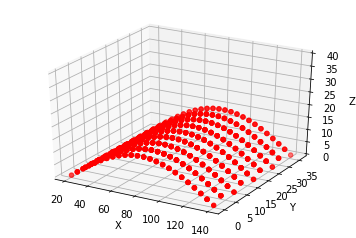

In [236]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x2[triangles1.flatten()], y2[triangles1.flatten()], z2[triangles1.flatten()], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim3d(0,40)
plt.show()

In [200]:
count = 0
lr = 0.001
x2, y2, z2 = x0.copy(), y0.copy(), z0.copy()
old_x, old_y, old_z = np.zeros(x0.shape), np.zeros(y0.shape), np.zeros(z0.shape)
dx, dy, dz = np.ones(x0.shape), np.ones(y0.shape), np.ones(z0.shape)
data3 = []
while np.linalg.norm(dx) > 1e-3 or np.linalg.norm(dy) > 1e-3 or np.linalg.norm(dz) > 1e-3:
    if count % 1000 == 0:
        print("Iteration:", count)
        data3.append(energy(triangles1, x2, y2, z2, a0=lambda x: end/(num - 1)*(1+0.001*((x-20)/120)**10)))
    dx, dy, dz = denergy(x2, y2, z2, triangles1, a0=lambda x: end/(num - 1)*(1+0.001*((x-20)/120)**10))
    old_x, old_y, old_z = x2.copy(), y2.copy(), z2.copy()
    x2 -= lr * dx
    y2 -= lr * dy
    z2 -= lr * dz
    count += 1
    if np.linalg.norm(dx) > 1e7 or np.linalg.norm(dy) > 1e7 or np.linalg.norm(dz) > 1e7:
        print("Overflow")
        break

Iteration: 0
Stretching: 0.00027893977118236387 Bending: 0.0 Total: 0.00027893977118236387
Iteration: 1000
Stretching: 0.00012410059543031717 Bending: 0.0 Total: 0.00012410059543031717
Iteration: 2000
Stretching: 8.098889588174226e-05 Bending: 0.0 Total: 8.098889588174226e-05
Iteration: 3000
Stretching: 5.867094663811638e-05 Bending: 0.0 Total: 5.867094663811638e-05
Iteration: 4000
Stretching: 4.46784072028519e-05 Bending: 0.0 Total: 4.46784072028519e-05
Iteration: 5000
Stretching: 3.5140026922870596e-05 Bending: 0.0 Total: 3.5140026922870596e-05
Iteration: 6000
Stretching: 2.8323807066296504e-05 Bending: 0.0 Total: 2.8323807066296504e-05
Iteration: 7000
Stretching: 2.3297003350496313e-05 Bending: 0.0 Total: 2.3297003350496313e-05
Iteration: 8000
Stretching: 1.9502087407192802e-05 Bending: 0.0 Total: 1.9502087407192802e-05
Iteration: 9000
Stretching: 1.6583234440025925e-05 Bending: 0.0 Total: 1.6583234440025925e-05
Iteration: 10000
Stretching: 1.4302929319587722e-05 Bending: 0.0 Total:

In [166]:
count = 0
lr = 0.001
x1, y1, z1 = x0.copy(), y0.copy(), z0.copy()
old_x, old_y, old_z = np.zeros(x0.shape), np.zeros(y0.shape), np.zeros(z0.shape)
dx, dy, dz = np.ones(x0.shape), np.ones(y0.shape), np.ones(z0.shape)
data2 = []
while np.linalg.norm(dx) > 1e-3 or np.linalg.norm(dy) > 1e-3 or np.linalg.norm(dz) > 1e-3:
    if count % 1000 == 0:
        print("Iteration:", count)
        data2.append(energy(triangles, x1, y1, z1, a0=lambda x: 2*end/(num - 1)))
    dx, dy, dz = denergy(x1, y1, z1, triangles, a0=lambda x: 2*end/(num - 1))
    old_x, old_y, old_z = x.copy(), y.copy(), z.copy()
    x1 -= lr * dx
    y1 -= lr * dy
    z1 -= lr * dz
    count += 1
    if np.linalg.norm(dx) > 1e7 or np.linalg.norm(dy) > 1e7 or np.linalg.norm(dz) > 1e7:
        print("Overflow")
        break

Iteration: 0
Stretching: 426.05571111389554 Bending: 0.0 Total: 426.05571111389554
Iteration: 1000
Stretching: 261.63021969288764 Bending: 0.0 Total: 261.63021969288764
Iteration: 2000
Stretching: 182.93171314148287 Bending: 0.0 Total: 182.93171314148287
Iteration: 3000
Stretching: 132.1848678021299 Bending: 0.0 Total: 132.1848678021299
Iteration: 4000
Stretching: 96.37591367732124 Bending: 0.0 Total: 96.37591367732124
Iteration: 5000
Stretching: 70.53935674239814 Bending: 0.0 Total: 70.53935674239814
Iteration: 6000
Stretching: 52.01807343337797 Bending: 0.0 Total: 52.01807343337797
Iteration: 7000
Stretching: 38.497623585498204 Bending: 0.0 Total: 38.497623585498204
Iteration: 8000
Stretching: 28.380078651933232 Bending: 0.0 Total: 28.380078651933232
Iteration: 9000
Stretching: 20.745314921581244 Bending: 0.0 Total: 20.745314921581244
Iteration: 10000
Stretching: 15.024192975900451 Bending: 0.0 Total: 15.024192975900451
Iteration: 11000
Stretching: 10.795826803729058 Bending: 0.0 Tot

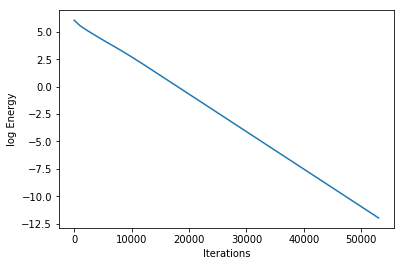

In [170]:
plt.plot(np.arange(0, 54000, 1000), np.log(data2))
plt.xlabel('Iterations')
plt.ylabel('log Energy')
plt.show()

In [140]:
triangles = tri.triangles
count = 0
lr = 0.001
x, y, z = x0.copy(), y0.copy(), z0.copy()
old_x, old_y, old_z = np.zeros(x0.shape), np.zeros(y0.shape), np.zeros(z0.shape)
dx, dy, dz = np.ones(x0.shape), np.ones(y0.shape), np.ones(z0.shape)
while np.linalg.norm(dx) > 1e-3 or np.linalg.norm(dy) > 1e-3 or np.linalg.norm(dz) > 1e-3:
    if count % 10000 == 0:
        print("Iteration:", count)
        energy(triangles, x, y, z, a0=10*end/(num - 1))
    dx, dy, dz = denergy(x, y, z, triangles, a0=10*end/(num - 1))
    old_x, old_y, old_z = x.copy(), y.copy(), z.copy()
    x -= lr * dx
    y -= lr * dy
    z -= lr * dz
    count += 1
    if np.linalg.norm(dx) > 1e7 or np.linalg.norm(dy) > 1e7 or np.linalg.norm(dz) > 1e7:
        print("Overflow")
        break

Iteration: 0
Stretching: 196414.56157831068 Bending: 0.0 Total: 196414.56157831068
Iteration: 10000
Stretching: 15482.696147056844 Bending: 0.0 Total: 15482.696147056844
Iteration: 20000
Stretching: 14109.656591878305 Bending: 0.0 Total: 14109.656591878305
Iteration: 30000
Stretching: 11640.53840593706 Bending: 0.0 Total: 11640.53840593706
Iteration: 40000
Stretching: 4112.415264587971 Bending: 0.0 Total: 4112.415264587971
Iteration: 50000
Stretching: 1644.4877053529142 Bending: 0.0 Total: 1644.4877053529142
Iteration: 60000
Stretching: 912.1394022776855 Bending: 0.0 Total: 912.1394022776855
Iteration: 70000
Stretching: 584.2309239218052 Bending: 0.0 Total: 584.2309239218052
Iteration: 80000
Stretching: 397.0283347392661 Bending: 0.0 Total: 397.0283347392661
Iteration: 90000
Stretching: 275.1356106066388 Bending: 0.0 Total: 275.1356106066388
Iteration: 100000
Stretching: 192.40882303099525 Bending: 0.0 Total: 192.40882303099525
Iteration: 110000
Stretching: 135.48664806361344 Bending: 

In [153]:
data = [196414.56157831068, 15482.696147056844, 14109.656591878305, 11640.53840593706, 4112.415264587971, 1644.4877053529142, 912.1394022776855, 584.2309239218052, 397.0283347392661, 275.1356106066388, 192.40882303099525, 135.48664806361344, 96.0283703187631, 68.50468, 49.1854, 35.536, 25.829, 18.87, 13.87, 10.24, 7.589, 5.645, 4.213, 3.15, 2.365, 1.778, 1.339, 1.01, 0.76, 0.57, 0.44, 0.33, 0.25, 0.19, 0.144, 0.11, 0.08, 0.06, 0.04, 0.03, 0.021, 0.016, 0.012, 0.009, 0.007, 0.005, 0.004, 0.003, 0.0024, 0.0018, 0.0014]


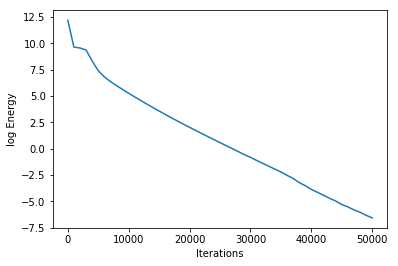

In [155]:
plt.plot(np.arange(0, 51000, 1000), np.log(data))
plt.xlabel('Iterations')
plt.ylabel('log Energy')
plt.show()

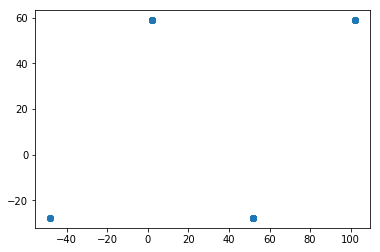

In [146]:
plt.scatter(x, y)
plt.show()

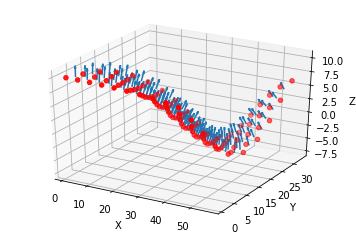

Stretching: 0.28835862469951307 Bending: 0.0009564351672762216 Total: 0.2893150598667893


0.2893150598667893

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

norms, cents, new_tri = find_normal(tri.triangles, x, y, z)
ax.quiver(cents[:, 0], cents[:, 1], cents[:, 2], norms[:, 0], norms[:, 1], norms[:, 2], length=2)
plt.show()

energy(tri.triangles, x, y, z)

In [271]:
def make_cut(start, end, triangles=tri.triangles, x=x0, y=y0, z=z0):
    def intersect(a, b):
        def helper(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
        return helper(a, start, end) != helper(b, start, end) \
           and helper(a, b, start) != helper(a, b, end)
    indices = []
    cut_indices = []
    for i, triangle in enumerate(triangles):
        coords = np.array([x[triangle.astype(int)], y[triangle.astype(int)], z[triangle.astype(int)]]).T
        if not intersect(coords[0], coords[1]) and not intersect(coords[1], coords[2]) \
                                               and not intersect(coords[0], coords[2]):
            indices.append(i)
        else:
            cut_indices.append(i)
    return triangles[indices], triangles[cut_indices]

# new_triangles = make_cut(np.array([0, 0]), np.array([30, 30]))

# print(energy(new_triangles))

In [13]:
import jax.numpy as jnp
from jax.experimental.ode import build_odeint, odeint
from jax import grad
from jax import jit

In [22]:
def jfind_normal(triangles, x=jnp.array(x), y=jnp.array(y), z=jnp.array(z)):
    normals, centers = [], []
    for triangle in triangles:
        coords = jnp.array([x[triangle.astype(int)], y[triangle.astype(int)], z[triangle.astype(int)]]).T
        norm = jnp.cross(coords[1] - coords[0], coords[2] - coords[0])
        normals.append((jnp.where(norm[-1] >= 0, norm, norm * -1)) / jnp.linalg.norm(norm))
        centers.append(jnp.mean(coords, axis=0))
    sorted_norms = jnp.sort(jnp.hstack([centers, normals, triangles]), axis=0)
    return sorted_norms[:, 3:6], sorted_norms[:, :3], sorted_norms[:, 6:]

def jenergy(triangles, S=0.1, B=1, a0=1.0*end/num):
    norms, cents, new_tri = jfind_normal(triangles)
    s_energy, b_energy = 0, 0
    already_added = dict()
    for triangle in new_tri:
        coords = jnp.array([jnp.array(x)[triangle.astype(int)], jnp.array(y)[triangle.astype(int)], jnp.array(z)[triangle.astype(int)]]).T
        for pair in [[0, 1], [0, 2], [1, 2]]:
            key = tuple(jnp.sort(triangle[pair]))
            s_energy += jnp.where(key not in already_added, (jnp.linalg.norm(coords[pair[0]] - coords[pair[1]]) - a0) ** 2, 0)
            already_added[key] = 1
    s_energy *= sqrt(3)/4*S
    triangles = dict()
    for i, triangle in enumerate(new_tri.astype(int)):
        low, high = max(i - num * 2, 0), min(i + num * 2, len(new_tri))
        for j, tri in enumerate(new_tri[low:high].astype(int)):
            overlap = 0
            for vertex in tri:
                if vertex in triangle:
                    overlap += 1
            if overlap == 2 and j + low not in triangles:
                b_energy += np.linalg.norm(norms[i] - norms[j + low]) ** 2
        triangles[i] = 1
    b_energy *= B/sqrt(3)/2
    print("Stretching:", s_energy, "Bending:", b_energy, "Total:", s_energy + b_energy)
    return s_energy + b_energy

dfdtri = jit(grad(jenergy, 0))
count = 0
lr = 0.001
triangles = jnp.array(tri.triangles).astype(float)
while np.abs(dfdtri(triangles)) > 1e-3:
    triangles -= lr * dfdtri(triangles)
    if count % 100 == 0:
        print("Iteration:", count)
        energy(triangles)
    count += 1
    if np.abs(dfdtri(triangles)) > 10000:
        print("Overflow")
        break

/Users/michaelyue/anaconda/lib/python3.6/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/michaelyue/anaconda/lib/python3.6/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


TypeError: unhashable type: 'JVPTracer'